In [93]:
import zipfile
import urllib.request
import random
import os
import pathlib
import numpy as np
import pandas as pd
import helper_functions as hf

import matplotlib.pylab as plt

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer

import tensorflow as tf
import tensorflow_hub as hub

 Variables in order:
- 0 CRIM     per capita crime rate by town
- 1 ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
- 2 INDUS    proportion of non-retail business acres per town
- 3 CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
- 4 NOX      nitric oxides concentration (parts per 10 million)
- 5 RM       average number of rooms per dwelling
- 6 AGE      proportion of owner-occupied units built prior to 1940
- 7 DIS      weighted distances to five Boston employment centres
- 8 RAD      index of accessibility to radial highways
- 9 TAX      full-value property-tax rate per $10,000
- 10 PTRATIO  pupil-teacher ratio by town
- 11 B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
- 11 LSTAT    % lower status of the population
- 12 MEDV     Median value of owner-occupied homes in $1000's

In [3]:
(X_train, y_train), (X_test,
                     y_test) = tf.keras.datasets.boston_housing.load_data(
                         test_split=0.2)


In [4]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((404, 13), (404,), (102, 13), (102,))

### i want to remove proportion of blacks in town value from tensors cuz its kinda racist in this context.

that value is at index -3

In [5]:
X_train[0]

array([  1.23247,   0.     ,   8.14   ,   0.     ,   0.538  ,   6.142  ,
        91.7    ,   3.9769 ,   4.     , 307.     ,  21.     , 396.9    ,
        18.72   ])

testing how i could do it

In [6]:
test = X_train.copy()
test = tf.concat([test[:,:-3],test[:,-2:]],1)
test[0]

2023-03-01 17:10:13.038901: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<tf.Tensor: shape=(12,), dtype=float64, numpy=
array([  1.23247,   0.     ,   8.14   ,   0.     ,   0.538  ,   6.142  ,
        91.7    ,   3.9769 ,   4.     , 307.     , 396.9    ,  18.72   ])>

In [7]:
test[0]

<tf.Tensor: shape=(12,), dtype=float64, numpy=
array([  1.23247,   0.     ,   8.14   ,   0.     ,   0.538  ,   6.142  ,
        91.7    ,   3.9769 ,   4.     , 307.     , 396.9    ,  18.72   ])>

that worked so lets do it on all relevant tensors

NOTE: only run once otherwise it will keep shorting the tensor

NOTE: i just noticed data type is in float64... i mihgt have to change that

In [8]:
X_train = tf.concat([X_train[:,:-3],X_train[:,-2:]],1)
X_test = tf.concat([X_test[:,:-3],X_test[:,-2:]],1)
X_train[0],X_test[0]

(<tf.Tensor: shape=(12,), dtype=float64, numpy=
 array([  1.23247,   0.     ,   8.14   ,   0.     ,   0.538  ,   6.142  ,
         91.7    ,   3.9769 ,   4.     , 307.     , 396.9    ,  18.72   ])>,
 <tf.Tensor: shape=(12,), dtype=float64, numpy=
 array([ 18.0846,   0.    ,  18.1   ,   0.    ,   0.679 ,   6.434 ,
        100.    ,   1.8347,  24.    , 666.    ,  27.25  ,  29.05  ])>)

## Creating simple model before preprocessing

originally i had a model that was quite simple and worked as baseline. but then i found one online close to what i had that seemed like a much better baseline so im using that

In [350]:
tf.random.set_seed(42)
model0 = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation="relu",
                          input_shape=[len(X_train[0])]),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1)
])

model0.compile(loss="mse",
               optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
               metrics=["mse", "mae", "accuracy"])

history0 = model0.fit(
    X_train,
    y_train,
    epochs=200,
    batch_size=64,
    validation_data=(X_test, y_test),
)

Epoch 1/200
7/7 [==============================] - 4s 55ms/step - loss: 3799.9043 - mse: 3799.9043 - mae: 45.0907 - accuracy: 0.0000e+00 - val_loss: 244.6932 - val_mse: 244.6932 - val_mae: 13.3186 - val_accuracy: 0.0000e+00
Epoch 2/200
7/7 [==============================] - 0s 24ms/step - loss: 458.9295 - mse: 458.9295 - mae: 16.6927 - accuracy: 0.0000e+00 - val_loss: 170.6408 - val_mse: 170.6408 - val_mae: 10.5375 - val_accuracy: 0.0000e+00
Epoch 3/200
7/7 [==============================] - 0s 15ms/step - loss: 260.3316 - mse: 260.3316 - mae: 12.5732 - accuracy: 0.0000e+00 - val_loss: 130.7289 - val_mse: 130.7289 - val_mae: 8.8242 - val_accuracy: 0.0000e+00
Epoch 4/200
7/7 [==============================] - 0s 14ms/step - loss: 202.7788 - mse: 202.7788 - mae: 10.7344 - accuracy: 0.0000e+00 - val_loss: 104.6969 - val_mse: 104.6969 - val_mae: 7.5706 - val_accuracy: 0.0000e+00
Epoch 5/200
7/7 [==============================] - 0s 11ms/step - loss: 173.3383 - mse: 173.3383 - mae: 10.0595 

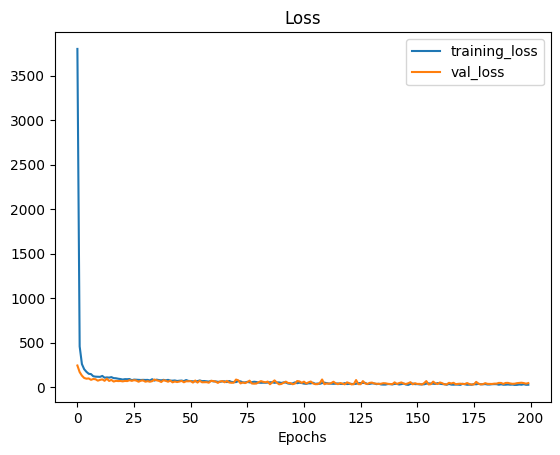

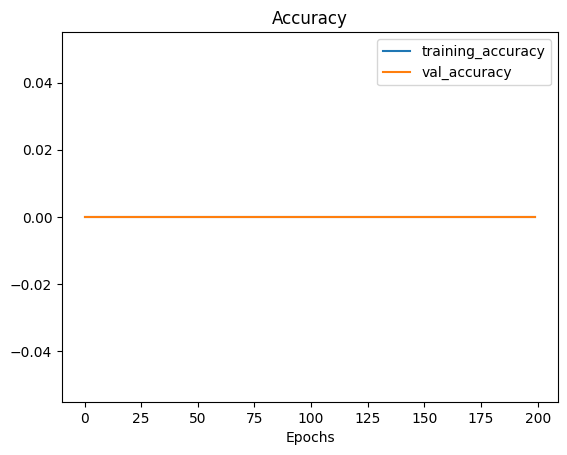

In [351]:
hf.plot_loss_curves(history0)

In [352]:
preds = model0.predict(X_test)

4/4 [==============================] - 0s 4ms/step


In [353]:
for i in range(15):
    print(preds[i,0],y_test[i])

9.933523 7.2
15.874877 18.8
19.397726 19.0
29.153961 27.0
20.226337 22.2
17.75255 24.5
25.228214 31.2
20.20784 22.9
15.668993 20.5
15.143744 23.2
14.729076 18.6
15.776584 14.5
14.8089905 17.8
32.405727 50.0
11.535988 20.8


## preproccessing data

In [144]:
X_train_df = pd.DataFrame(X_train,)
X_test_df = pd.DataFrame(X_test)
X_train_df[:10]

,0,1,2,3,4,5,6,7,8,9,10,11
0,1.23247,0.0,8.14,0.0,0.538,6.142,91.7,3.9769,4.0,307.0,396.90,18.72
1,0.02177,82.5,2.03,0.0,0.415,7.610,15.7,6.2700,2.0,348.0,395.38,3.11
2,4.89822,0.0,18.10,0.0,0.631,4.970,100.0,1.3325,24.0,666.0,375.52,3.26
3,0.03961,0.0,5.19,0.0,0.515,6.037,34.5,5.9853,5.0,224.0,396.90,8.01
4,3.69311,0.0,18.10,0.0,0.713,6.376,88.4,2.5671,24.0,666.0,391.43,14.65
5,0.28392,0.0,7.38,0.0,0.493,5.708,74.3,4.7211,5.0,287.0,391.13,11.74
6,9.18702,0.0,18.10,0.0,0.700,5.536,100.0,1.5804,24.0,666.0,396.90,23.60
7,4.09740,0.0,19.58,0.0,0.871,5.468,100.0,1.4118,5.0,403.0,396.90,26.42
8,2.15505,0.0,19.58,0.0,0.871,5.628,100.0,1.5166,5.0,403.0,169.27,16.65
9,1.62864,0.0,21.89,0.0,0.624,5.019,100.0,1.4394,4.0,437.0,396.90,34.41


In [69]:
X_train_df.describe().transpose()[["mean","min","max"]]

,mean,min,max
0,3.745111,0.00632,88.9762
1,11.480198,0.00000,100.0000
2,11.104431,0.46000,27.7400
3,0.061881,0.00000,1.0000
4,0.557356,0.38500,0.8710
5,6.267082,3.56100,8.7250
6,69.010644,2.90000,100.0000
7,3.740271,1.12960,10.7103
8,9.440594,1.00000,24.0000
9,405.898515,188.00000,711.0000


 Variables in order:
- 0 % CRIM
- 1 % ZN
- 2 % INDUS
- 3 1 CHAS
- 4 # NOX
- 5 # RM
- 6 % AGE
- 7 # DIS
- 8 # RAD
- 9 # TAX
- 10 # PTRATIO
- 11 LSTAT    % lower status of the population
- 12 MEDV     Median value of owner-occupied homes in $1000's

In [128]:
# divid these columns by 100 to normalize
percentage_columns = [0,1,2,6]
# MinMax normalize these columns
numerical_columns = [4,5,7,8,9,10,11]
all = [0,1,2,3,4,5,6,7,8,9,10,11]

to clearify the below cell is used because the standard data normalization will take the max and min values of to normalize. however since `percentage_columns` are percentages i want to normalize them with min-max of 0-1.

i.e. 66 will be equal to .66 and not .672523559

as for the numerical_columns those can be normalized via the standard methods because there is not absolute max so just use the max() of the data itself hense MinMaxScalar()

In [129]:
# function to use in functiontransformer. converts tensors into percentage
def percentage_normalizer(data: np.array):
    norm_data = np.divide(data,100)
    return norm_data

and heres the interesting part. a problem that i searched to try to figure out but couldnt figure out is: using make_column_transformer mixes up the order of the columns in the tensor. so percentage_columns is first done then numerical_columns then remainders all this is then later concatanated.

make_column_transformer doesnt have an inbuild func to preserve column order so you could either
1. list them in order in the transformer
2. or ideally convert the tensors to a df then do all your preprocessing.

however after some thinking i dont think this order will cause an issue as long as your test data and any further data is put thro this transformation as well...

In [149]:
ct = make_column_transformer(
     (FunctionTransformer(percentage_normalizer),percentage_columns),
     (MinMaxScaler(),numerical_columns),
     remainder="passthrough",
)
X_train_normal = ct.fit_transform(X_train_df)
X_test_normal = ct.fit_transform(X_test_df)

In [151]:
X_train_normal.shape,X_train.shape

((404, 12), TensorShape([404, 12]))

In [148]:
i = 3
l = 0
X_train_normal[l],X_train[l]

(array([0.0123247 , 0.        , 0.0814    , 0.917     , 0.31481481,
        0.49980635, 0.29719123, 0.13043478, 0.22753346, 1.        ,
        0.46881898, 0.        ]),
 <tf.Tensor: shape=(12,), dtype=float64, numpy=
 array([  1.23247,   0.     ,   8.14   ,   0.     ,   0.538  ,   6.142  ,
         91.7    ,   3.9769 ,   4.     , 307.     , 396.9    ,  18.72   ])>)

In [153]:
i = 3
l = 0
X_test_normal[l],X_test[l]

(array([0.180846  , 0.        , 0.181     , 1.        , 0.59916493,
        0.39846154, 0.0346309 , 1.        , 0.91412214, 0.00698455,
        0.90222813, 0.        ]),
 <tf.Tensor: shape=(12,), dtype=float64, numpy=
 array([ 18.0846,   0.    ,  18.1   ,   0.    ,   0.679 ,   6.434 ,
        100.    ,   1.8347,  24.    , 666.    ,  27.25  ,  29.05  ])>)

## model with preprocessed data?

In [402]:
tf.random.set_seed(42)
model1 = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation="relu",
                          input_shape=[len(X_train_normal[0])]),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1)
])

model1.compile(loss="mse",
               optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
               metrics=["mse", "mae", "accuracy"])

history1 = model1.fit(
    X_train_normal,
    y_train,
    epochs=200,
    batch_size=64,
    validation_data=(X_test_normal, y_test),
)

Epoch 1/200
7/7 [==============================] - 2s 77ms/step - loss: 447.6429 - mse: 447.6429 - mae: 18.8595 - accuracy: 0.0000e+00 - val_loss: 172.2714 - val_mse: 172.2714 - val_mae: 10.5274 - val_accuracy: 0.0000e+00
Epoch 2/200
7/7 [==============================] - 0s 21ms/step - loss: 157.1010 - mse: 157.1010 - mae: 9.9614 - accuracy: 0.0000e+00 - val_loss: 96.6022 - val_mse: 96.6022 - val_mae: 7.4021 - val_accuracy: 0.0000e+00
Epoch 3/200
7/7 [==============================] - 0s 18ms/step - loss: 101.7671 - mse: 101.7671 - mae: 7.2919 - accuracy: 0.0000e+00 - val_loss: 102.7583 - val_mse: 102.7583 - val_mae: 7.6673 - val_accuracy: 0.0000e+00
Epoch 4/200
7/7 [==============================] - 0s 19ms/step - loss: 77.0649 - mse: 77.0649 - mae: 6.1181 - accuracy: 0.0000e+00 - val_loss: 59.5122 - val_mse: 59.5122 - val_mae: 5.7806 - val_accuracy: 0.0000e+00
Epoch 5/200
7/7 [==============================] - 0s 13ms/step - loss: 66.3439 - mse: 66.3439 - mae: 5.9359 - accuracy: 0.0

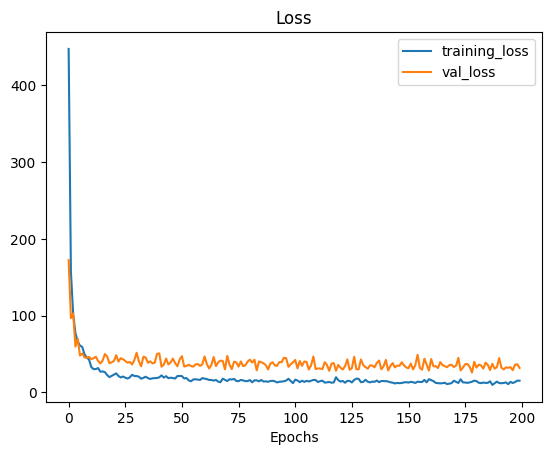

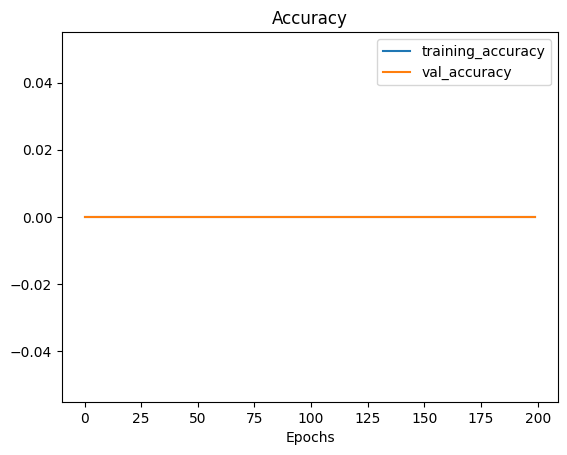

In [403]:
hf.plot_loss_curves(history1)

In [404]:
preds1 = model1.predict(X_test_normal)

4/4 [==============================] - 0s 4ms/step


In [405]:
for i in range(15):
    print(preds1[i,0],y_test[i])

9.604634 7.2
17.951904 18.8
20.254515 19.0
31.25545 27.0
20.714247 22.2
18.872328 24.5
26.00146 31.2
19.740532 22.9
18.311773 20.5
18.52178 23.2
17.364748 18.6
18.297285 14.5
16.194208 17.8
43.92073 50.0
16.857214 20.8


In [406]:
tf.random.set_seed(42)
model1 = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation="relu",
                          input_shape=[len(X_train_normal[0])]),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(1)
])

model1.compile(loss="mse",
               optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
               metrics=["mse", "mae", "accuracy"])

history1 = model1.fit(
    X_train_normal,
    y_train,
    epochs=200,
    batch_size=64,
    validation_data=(X_test_normal, y_test),
)

Epoch 1/200
7/7 [==============================] - 3s 55ms/step - loss: 435.4788 - mse: 435.4788 - mae: 18.2881 - accuracy: 0.0000e+00 - val_loss: 316.5408 - val_mse: 316.5408 - val_mae: 14.0510 - val_accuracy: 0.0000e+00
Epoch 2/200
7/7 [==============================] - 0s 13ms/step - loss: 165.9996 - mse: 165.9996 - mae: 9.8425 - accuracy: 0.0000e+00 - val_loss: 123.3501 - val_mse: 123.3501 - val_mae: 8.6604 - val_accuracy: 0.0000e+00
Epoch 3/200
7/7 [==============================] - 0s 13ms/step - loss: 74.5140 - mse: 74.5140 - mae: 6.9342 - accuracy: 0.0000e+00 - val_loss: 57.8795 - val_mse: 57.8795 - val_mae: 5.5095 - val_accuracy: 0.0000e+00
Epoch 4/200
7/7 [==============================] - 0s 34ms/step - loss: 72.3043 - mse: 72.3043 - mae: 5.7767 - accuracy: 0.0000e+00 - val_loss: 58.5219 - val_mse: 58.5219 - val_mae: 5.5423 - val_accuracy: 0.0000e+00
Epoch 5/200
7/7 [==============================] - 0s 15ms/step - loss: 52.7534 - mse: 52.7534 - mae: 5.5782 - accuracy: 0.000

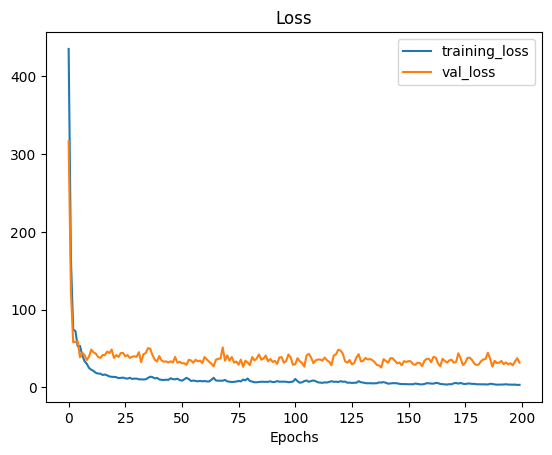

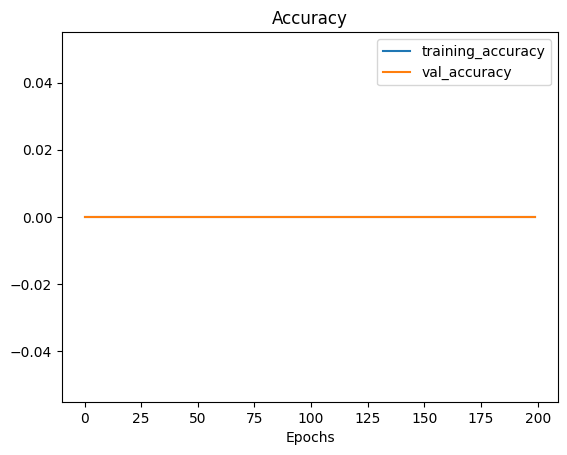

In [407]:
hf.plot_loss_curves(history1)

In [408]:
preds1 = model1.predict(X_test_normal)

4/4 [==============================] - 0s 3ms/step


In [409]:
for i in range(100):
    print(preds1[i,0],y_test[i])

12.0773 7.2
14.898266 18.8
19.555202 19.0
23.681126 27.0
20.166481 22.2
19.616398 24.5
22.973026 31.2
18.861969 22.9
16.914825 20.5
18.414024 23.2
17.105392 18.6
14.225316 14.5
13.018951 17.8
43.80143 50.0
18.969608 20.8
17.278385 24.3
21.74886 24.2
16.988346 19.8
16.379776 19.1
16.83797 22.7
15.210527 12.0
13.598895 10.2
19.561565 20.0
15.097576 18.5
17.021286 20.9
19.408062 23.0
25.244007 27.5
23.779552 30.1
13.434454 9.5
16.878738 22.0
17.046429 21.2
15.393553 14.1
26.819069 33.1
20.899345 23.4
16.108189 20.1
11.23009 7.4
15.025771 15.4
14.862712 23.8
17.266811 20.1
21.07278 24.5
23.144695 33.0
21.787647 28.4
11.956867 14.1
40.494774 46.7
25.669716 32.5
25.389 29.6
23.789928 28.4
16.007633 19.8
18.23663 20.2
19.046036 25.0
28.923325 35.4
16.635586 20.3
13.606757 9.7
13.9695425 14.5
29.399261 34.9
21.575176 26.6
11.444813 7.2
44.815945 50.0
26.719887 32.4
18.3088 21.6
20.35785 29.8
12.827598 13.1
16.111582 27.5
17.895687 21.2
19.396996 23.1
17.916817 21.9
11.875443 13.0
18.84019 23.2